In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [2]:
path_train = '/Users/kelsey/Downloads/ASL_Alphabet_Dataset/asl_alphabet_train'
path_test = '/Users/kelsey/Downloads/PROJECT CODE/test'

In [3]:
train = list(glob.glob(path_train+'/**/*.jpg'))
test = list(glob.glob(path_test+'/*.jpg'))

In [4]:
def process(file_path):
    labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], file_path))
    filepath = pd.Series(file_path, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [5]:
data = process(train)
data.head()

FilePath Label
0  /Users/kelsey/Downloads/ASL_Alphabet_Dataset/a...     O
1  /Users/kelsey/Downloads/ASL_Alphabet_Dataset/a...     B
2  /Users/kelsey/Downloads/ASL_Alphabet_Dataset/a...     J
3  /Users/kelsey/Downloads/ASL_Alphabet_Dataset/a...     D
4  /Users/kelsey/Downloads/ASL_Alphabet_Dataset/a...     R

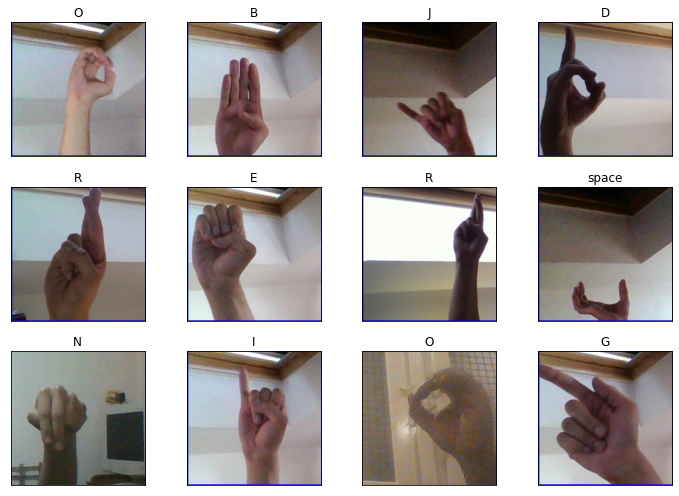

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.FilePath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()


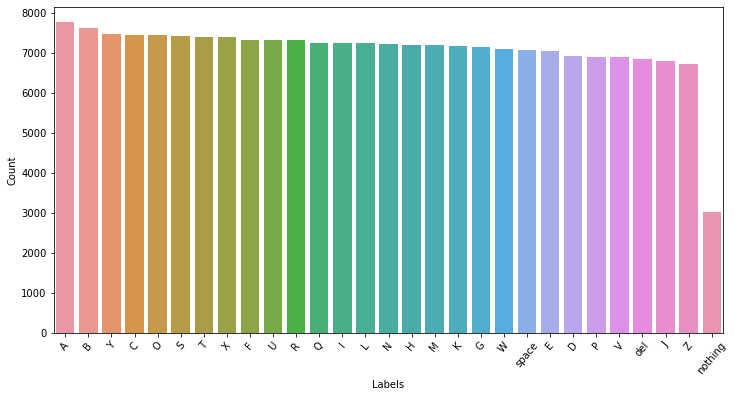

In [7]:
plt.figure(figsize=(12, 6))
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [8]:
train_df, test_df = train_test_split(data, train_size=0.7, random_state=1)

In [9]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='FilePath',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='FilePath',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='FilePath',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [10]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(120, activation='relu')(pre_model.output)
    x = Dense(120, activation='relu')(x)
    outputs = Dense(29, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [11]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Label,pred)
    clr = classification_report(test_df.Label, pred)
    print(clr)
    print(cm)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.FilePath.iloc[i+1]))
        ax.set_title(f"True: {test_df.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [12]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# VGG16 MODEL

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 114757 validated image filenames belonging to 29 classes.
Found 28689 validated image filenames belonging to 29 classes.
Found 61478 validated image filenames belonging to 29 classes.


In [14]:
model_VGG16, callback=func(VGG16)

Metal device set to: Apple M1


2022-04-27 12:01:28.478748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 12:01:28.479635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback
)

2022-04-27 12:01:28.969535: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-04-27 12:01:29.274932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3587/3587 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8911

2022-04-27 12:08:55.170362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3587/3587 [==============================] - 568s 158ms/step - loss: 0.3806 - accuracy: 0.8911 - val_loss: 0.1754 - val_accuracy: 0.9431
Epoch 2/100
3587/3587 [==============================] - 804s 224ms/step - loss: 0.1156 - accuracy: 0.9641 - val_loss: 0.1103 - val_accuracy: 0.9665
Epoch 3/100
3587/3587 [==============================] - 2436s 679ms/step - loss: 0.0809 - accuracy: 0.9745 - val_loss: 0.0829 - val_accuracy: 0.9753
Epoch 4/100
3587/3587 [==============================] - 5371s 1s/step - loss: 0.0680 - accuracy: 0.9791 - val_loss: 0.0768 - val_accuracy: 0.9808
Epoch 5/100
3587/3587 [==============================] - 2220s 619ms/step - loss: 0.0611 - accuracy: 0.9820 - val_loss: 0.0830 - val_accuracy: 0.9785


2022-04-27 15:11:28.350332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           A       0.99      0.97      0.98      2345
           B       0.99      0.99      0.99      2295
           C       0.99      0.99      0.99      2294
           D       1.00      0.96      0.98      2095
           E       0.97      0.98      0.97      2079
           F       0.99      0.99      0.99      2283
           G       0.99      0.97      0.98      2119
           H       0.97      0.99      0.98      2148
           I       0.95      0.99      0.97      2202
           J       1.00      0.99      0.99      2061
           K       0.98      0.98      0.98      2155
           L       0.99      0.98      0.99      2142
           M       0.97      0.99      0.98      2172
           N       0.98      0.98      0.98      2128
           O       0.99      0.99      0.99      2245
           P       0.98      1.00      0.99      2051
           Q       0.98      0.98      0.98      2182
           R       0.99    

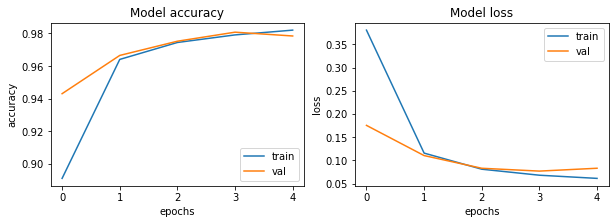

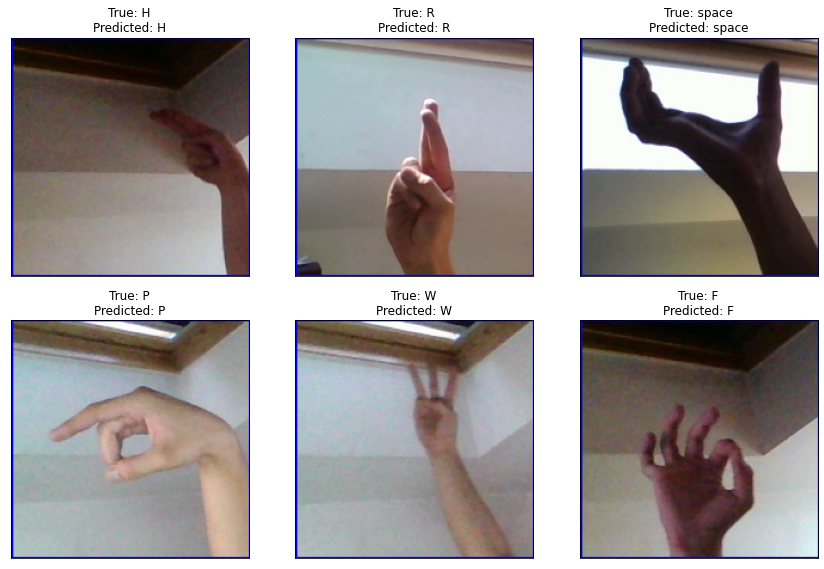

In [16]:
import matplotlib.pyplot as plt
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)

In [17]:
result = result_test(test_gen_VGG,model_VGG16)

    Test Loss: 0.07742
Test Accuracy: 98.05%


In [18]:
  # Saving the model
MODEL_NAME = 'models/asl_predict11_{}.h5'.format(9575)
model_VGG16.save(MODEL_NAME)

# RESNET 50

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df, test_df)

Found 114757 validated image filenames belonging to 29 classes.
Found 28689 validated image filenames belonging to 29 classes.
Found 61478 validated image filenames belonging to 29 classes.


In [20]:
ResNet50_model, callback=func(ResNet50)

In [21]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=50,
    callbacks=callback
)

Epoch 1/50


2022-04-27 15:34:31.954007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3587/3587 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8704

2022-04-27 15:51:24.301090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3587/3587 [==============================] - 1697s 473ms/step - loss: 0.4152 - accuracy: 0.8704 - val_loss: 0.1784 - val_accuracy: 0.9427
Epoch 2/50
3587/3587 [==============================] - 1373s 383ms/step - loss: 0.1534 - accuracy: 0.9492 - val_loss: 0.1399 - val_accuracy: 0.9568
Epoch 3/50
3587/3587 [==============================] - 534s 149ms/step - loss: 0.1113 - accuracy: 0.9637 - val_loss: 0.1411 - val_accuracy: 0.9555


2022-04-27 16:34:35.268491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           A       0.93      0.98      0.96      2345
           B       0.98      0.96      0.97      2295
           C       0.99      0.97      0.98      2294
           D       0.98      0.98      0.98      2095
           E       0.99      0.93      0.96      2079
           F       0.99      0.97      0.98      2283
           G       0.94      0.99      0.96      2119
           H       0.99      0.96      0.98      2148
           I       0.97      0.96      0.97      2202
           J       0.99      0.97      0.98      2061
           K       0.98      0.89      0.93      2155
           L       0.98      0.98      0.98      2142
           M       0.96      0.97      0.97      2172
           N       0.97      0.96      0.96      2128
           O       0.97      0.98      0.98      2245
           P       0.93      1.00      0.96      2051
           Q       0.99      0.96      0.97      2182
           R       0.96    

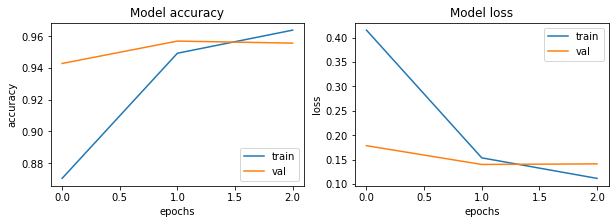

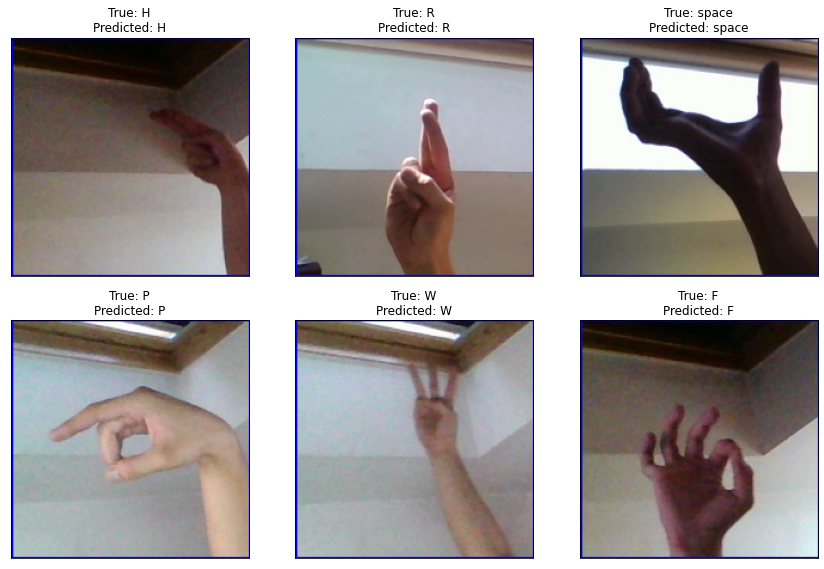

In [22]:
history_ResNet=plot(history,test_gen_RestNet,train_gen_RestNet,ResNet50_model)

In [29]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 0.13688
Test Accuracy: 95.76%


# FINAL REPORT

In [36]:
output = pd.DataFrame({'Model':['VGG16','ResNet50'],
                      'Accuracy':[result[1], result_ResNet[1]]})

In [37]:
output

Model  Accuracy
0     VGG16  0.980465
1  ResNet50  0.957595

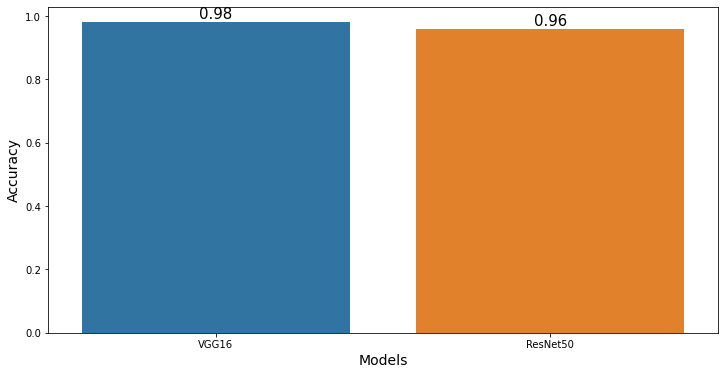

In [38]:
plt.figure(figsize=(12, 6))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()